# Interacting with CLIP

This is a self-contained notebook that shows how to download and run CLIP models, calculate the similarity between arbitrary image and text inputs, and perform zero-shot image classifications.


# Parameters

In [ ]:
ipfs_path = "/content/ipfs"

experiment_name = "tiergarten_3"

experiment_path = f"{ipfs_path}/video_to_clip/{experiment_name}"

results_path = f"{experiment_path}/results"

top_classes=10

# The words only take effect if cifar is False (otherwise the 100 CIFAR categories will be used)
cifar = True
words = ["Happiness", "Excitement", "Boredom", "Sadness","Anger", "Disgust", "Fear"] 


# Preparation for Colab

Make sure you're running a GPU runtime; if not, select "GPU" as the hardware accelerator in Runtime > Change Runtime Type in the menu. The next cells will print the CUDA version of the runtime if it has a GPU, and install PyTorch 1.7.1.

In [ ]:
!mkdir -p $results_path
%cd /content
!git clone https://github.com/voodoohop/pollinations.git
%cd /content/pollinations/app
!git pull
!npm install
!npm install -g
%cd -
#!npm install forever -g

In [ ]:
IPFS_ROOT = "/content/ipfs"
DATA_PATH = IPFS_ROOT+"/tiergarten/frames_8fps"
!echo "Num input images:" `ls -l {DATA_PATH}/*.jpg {DATA_PATH}/*.png 2>/dev/null | wc -l`

In [ ]:

#!echo QmS9QPuxZxdS7LWaMmBzcjUZ4Qe5MtFcDndEZZkhbbxKmD | DEBUG=* pollinate -p $IPFS_ROOT -r 


In [ ]:
#!mkdir -p /content/ipfs/tiergarten/frames_8fps/valence_ourasl
#!ffmpeg -i /content/ipfs/tiergarten-long.mp4 -r 8 /content/ipfs/tiergarten/frames_8fps/frame_%04d.png

In [ ]:
#!ffmpeg -i "/content/ipfs/tiergarten/frames_8fps/"%*.png /content/valenceArousel.mp4


In [ ]:
import subprocess

CUDA_version = [s for s in subprocess.check_output(["nvcc", "--version"]).decode("UTF-8").split(", ") if s.startswith("release")][0].split(" ")[-1]
print("CUDA version:", CUDA_version)

if CUDA_version == "10.0":
    torch_version_suffix = "+cu100"
elif CUDA_version == "10.1":
    torch_version_suffix = "+cu101"
elif CUDA_version == "10.2":
    torch_version_suffix = ""
else:
    torch_version_suffix = "+cu110"

In [ ]:
! pip install torch==1.7.1{torch_version_suffix} torchvision==0.8.2{torch_version_suffix} -f https://download.pytorch.org/whl/torch_stable.html ftfy regex tqdm

In [ ]:
import numpy as np
import torch

print("Torch version:", torch.__version__)

# Downloading the model

CLIP models are distributed as TorchScript modules.

In [ ]:
MODELS = {
    "RN50": "https://openaipublic.azureedge.net/clip/models/afeb0e10f9e5a86da6080e35cf09123aca3b358a0c3e3b6c78a7b63bc04b6762/RN50.pt",
    "RN101": "https://openaipublic.azureedge.net/clip/models/8fa8567bab74a42d41c5915025a8e4538c3bdbe8804a470a72f30b0d94fab599/RN101.pt",
    "RN50x4": "https://openaipublic.azureedge.net/clip/models/7e526bd135e493cef0776de27d5f42653e6b4c8bf9e0f653bb11773263205fdd/RN50x4.pt",
    "ViT-B/32": "https://openaipublic.azureedge.net/clip/models/40d365715913c9da98579312b702a82c18be219cc2a73407c4526f58eba950af/ViT-B-32.pt",    
}

In [ ]:
! wget {MODELS["ViT-B/32"]} -O model.pt

In [ ]:
model = torch.jit.load("model.pt").cuda().eval()
input_resolution = model.input_resolution.item()
context_length = model.context_length.item()
vocab_size = model.vocab_size.item()

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

# Image Preprocessing

We resize the input images and center-crop them to conform with the image resolution that the model expects. Before doing so, we will normalize the pixel intensity using the dataset mean and standard deviation.



In [ ]:
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
from PIL import Image

preprocess = Compose([
    Resize(input_resolution, interpolation=Image.BICUBIC),
    CenterCrop(input_resolution),
    ToTensor()
])

image_mean = torch.tensor([0.48145466, 0.4578275, 0.40821073]).cuda()
image_std = torch.tensor([0.26862954, 0.26130258, 0.27577711]).cuda()

# Text Preprocessing

We use a case-insensitive tokenizer. The tokenizer code is hidden in the second cell below

In [ ]:
! pip install ftfy regex
! wget https://openaipublic.azureedge.net/clip/bpe_simple_vocab_16e6.txt.gz -O bpe_simple_vocab_16e6.txt.gz

In [ ]:
#@title

import gzip
import html
import os
from functools import lru_cache

import ftfy
import regex as re


@lru_cache()
def bytes_to_unicode():
    """
    Returns list of utf-8 byte and a corresponding list of unicode strings.
    The reversible bpe codes work on unicode strings.
    This means you need a large # of unicode characters in your vocab if you want to avoid UNKs.
    When you're at something like a 10B token dataset you end up needing around 5K for decent coverage.
    This is a signficant percentage of your normal, say, 32K bpe vocab.
    To avoid that, we want lookup tables between utf-8 bytes and unicode strings.
    And avoids mapping to whitespace/control characters the bpe code barfs on.
    """
    bs = list(range(ord("!"), ord("~")+1))+list(range(ord("¡"), ord("¬")+1))+list(range(ord("®"), ord("ÿ")+1))
    cs = bs[:]
    n = 0
    for b in range(2**8):
        if b not in bs:
            bs.append(b)
            cs.append(2**8+n)
            n += 1
    cs = [chr(n) for n in cs]
    return dict(zip(bs, cs))


def get_pairs(word):
    """Return set of symbol pairs in a word.
    Word is represented as tuple of symbols (symbols being variable-length strings).
    """
    pairs = set()
    prev_char = word[0]
    for char in word[1:]:
        pairs.add((prev_char, char))
        prev_char = char
    return pairs


def basic_clean(text):
    text = ftfy.fix_text(text)
    text = html.unescape(html.unescape(text))
    return text.strip()


def whitespace_clean(text):
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    return text


class SimpleTokenizer(object):
    def __init__(self, bpe_path: str = "bpe_simple_vocab_16e6.txt.gz"):
        self.byte_encoder = bytes_to_unicode()
        self.byte_decoder = {v: k for k, v in self.byte_encoder.items()}
        merges = gzip.open(bpe_path).read().decode("utf-8").split('\n')
        merges = merges[1:49152-256-2+1]
        merges = [tuple(merge.split()) for merge in merges]
        vocab = list(bytes_to_unicode().values())
        vocab = vocab + [v+'</w>' for v in vocab]
        for merge in merges:
            vocab.append(''.join(merge))
        vocab.extend(['<|startoftext|>', '<|endoftext|>'])
        self.encoder = dict(zip(vocab, range(len(vocab))))
        self.decoder = {v: k for k, v in self.encoder.items()}
        self.bpe_ranks = dict(zip(merges, range(len(merges))))
        self.cache = {'<|startoftext|>': '<|startoftext|>', '<|endoftext|>': '<|endoftext|>'}
        self.pat = re.compile(r"""<\|startoftext\|>|<\|endoftext\|>|'s|'t|'re|'ve|'m|'ll|'d|[\p{L}]+|[\p{N}]|[^\s\p{L}\p{N}]+""", re.IGNORECASE)

    def bpe(self, token):
        if token in self.cache:
            return self.cache[token]
        word = tuple(token[:-1]) + ( token[-1] + '</w>',)
        pairs = get_pairs(word)

        if not pairs:
            return token+'</w>'

        while True:
            bigram = min(pairs, key = lambda pair: self.bpe_ranks.get(pair, float('inf')))
            if bigram not in self.bpe_ranks:
                break
            first, second = bigram
            new_word = []
            i = 0
            while i < len(word):
                try:
                    j = word.index(first, i)
                    new_word.extend(word[i:j])
                    i = j
                except:
                    new_word.extend(word[i:])
                    break

                if word[i] == first and i < len(word)-1 and word[i+1] == second:
                    new_word.append(first+second)
                    i += 2
                else:
                    new_word.append(word[i])
                    i += 1
            new_word = tuple(new_word)
            word = new_word
            if len(word) == 1:
                break
            else:
                pairs = get_pairs(word)
        word = ' '.join(word)
        self.cache[token] = word
        return word

    def encode(self, text):
        bpe_tokens = []
        text = whitespace_clean(basic_clean(text)).lower()
        for token in re.findall(self.pat, text):
            token = ''.join(self.byte_encoder[b] for b in token.encode('utf-8'))
            bpe_tokens.extend(self.encoder[bpe_token] for bpe_token in self.bpe(token).split(' '))
        return bpe_tokens

    def decode(self, tokens):
        text = ''.join([self.decoder[token] for token in tokens])
        text = bytearray([self.byte_decoder[c] for c in text]).decode('utf-8', errors="replace").replace('</w>', ' ')
        return text


# Setting up input images and texts

We are going to feed 8 example images and their textual descriptions to the model, and compare the similarity between the corresponding features.

The tokenizer is case-insensitive, and we can freely give any suitable textual descriptions.

In [ ]:
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from collections import OrderedDict
import torch

%matplotlib inline
%config InlineBackend.figure_format = 'retina'



In [ ]:

from tqdm.notebook import tqdm_notebook
images = []
#texts = []
plt.figure(figsize=(16, 16))
images_path = "/content/ipfs/tiergarten/frames_8fps"

filenames = os.listdir(images_path)
filenames.sort()
cols = 6
filenames = [filename for filename in filenames if filename.endswith(".png") or filename.endswith(".jpg")]
print("Preprocessing images...", len(filenames))
for filename in tqdm(filenames):
    i = len(images)
    #prop = i / len(images)
    name = os.path.splitext(filename)[0]

    try :
      image = preprocess(Image.open(os.path.join(images_path, filename)).convert("RGB"))
      images.append(image)
    
      #if i < cols*cols:
        
      #print(name)
      if i<cols*cols // 2:
        plt.subplot(6, 6, i+1)
        plt.imshow(image.permute(1, 2, 0))
        plt.title(f"{filename}\n")
        plt.xticks([])
        plt.yticks([])

        plt.tight_layout()
      
    except :
      print("Error reading image", name, "Deleting")
      !rm -v $filename

## Building features

We normalize the images, tokenize each text input, and run the forward pass of the model to get the image and text features.

In [ ]:
if cifar:
  from torchvision.datasets import CIFAR100
  words = CIFAR100(os.path.expanduser("~/.cache"), transform=preprocess, download=True).classes

text_descriptions = [f"The image is an abstract symbolization of {label.lower()}" for label in words]

In [ ]:
image_input = torch.tensor(np.stack(images)).cuda()
image_input -= image_mean[:, None, None]
image_input /= image_std[:, None, None]

In [ ]:
tokenizer = SimpleTokenizer()
text_tokens = [tokenizer.encode("This is " + desc) for desc in texts]

In [ ]:
text_input = torch.zeros(len(text_tokens), model.context_length, dtype=torch.long)
sot_token = tokenizer.encoder['<|startoftext|>']
eot_token = tokenizer.encoder['<|endoftext|>']

for i, tokens in enumerate(text_tokens):
    tokens = [sot_token] + tokens + [eot_token]
    text_input[i, :len(tokens)] = torch.tensor(tokens)

text_input = text_input.cuda()

In [ ]:
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    #text_features = model.encode_text(text_input).float()

## Calculating cosine similarity

We normalize the features and calculate the dot product of each pair.

# Zero-Shot Image Classification

You can classify images using the cosine similarity (times 100) as the logits to the softmax operation.

In [ ]:

with torch.no_grad():
    text_features = model.encode_text(text_input).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)


text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)



['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree',

<Figure size 432x288 with 0 Axes>

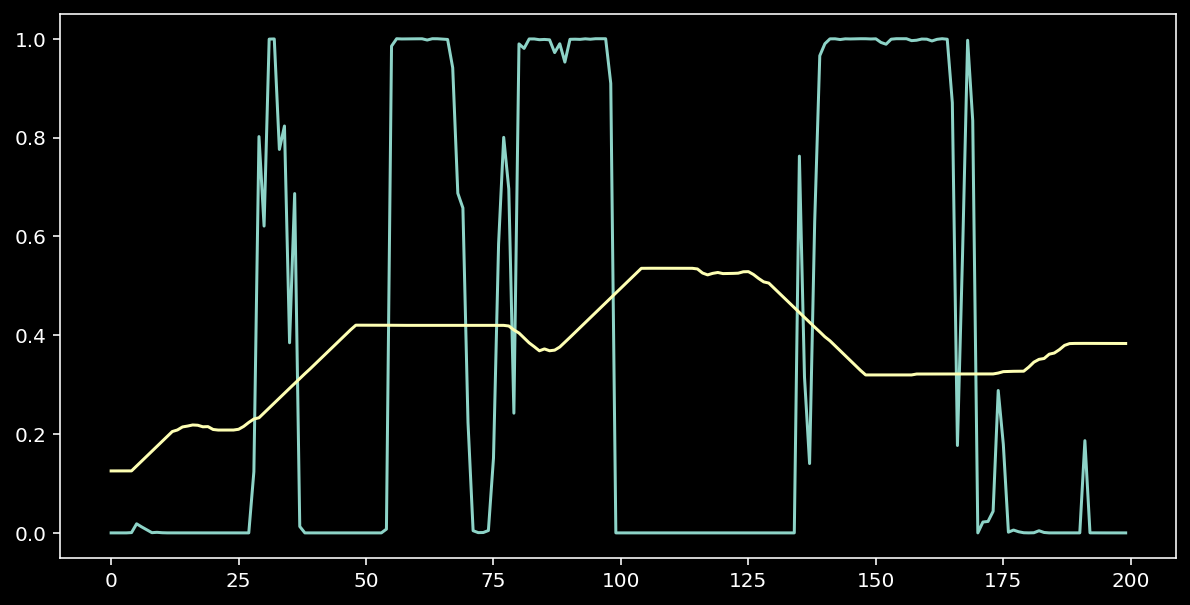

In [221]:
from scipy import ndimage

clear_output()
w = "lizard"
print(words)
n = words.index(w)

def moving_average(x, w):
    return ndimage.convolve(x, np.ones((w,1))) / w

# a uniform (boxcar) filter with a width of 50
text_probs_cpu = text_probs[900:1100].cpu()
#print(moving_average(text_probs_cpu,5).shape)

text_probs_smoothed = moving_average(text_probs_cpu,100)
# a Gaussian filter with a standard deviation of 10
#gauss = ndimage.gaussian_filter1d(img, 10, 1)
#text_probs_smoothed[0].shape



plt.clf()
plt.figure(figsize=(10,5))
plt.plot(text_probs_cpu[:,n])
plt.plot(text_probs_smoothed[:,n])
plt.show()



In [ ]:
text_probs.shape

disabled


```
from scipy import ndimage

clear_output()
w = "snail"

n = words.index(w)

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

# a uniform (boxcar) filter with a width of 50
text_probs_cpu = text_probs[1350:2000].cpu()
text_probs_smoothed = ndimage.gaussian_filter1d(text_probs_cpu,2,1)

# a Gaussian filter with a standard deviation of 10
#gauss = ndimage.gaussian_filter1d(img, 10, 1)
text_probs_smoothed[0].shape



plt.clf()
plt.figure(figsize=(10,5))
plt.plot(text_probs_cpu[:,n])
plt.plot(text_probs_smoothed[:,n])
plt.show()

```



In [230]:
#plot(text_probs.cpu().numpy())

top_probs, top_labels = text_probs.mean(0).cpu().topk(top_classes, dim=-1)

for index in top_labels:
  print(words[index])


snail
willow_tree
aquarium_fish
maple_tree
caterpillar
lizard
flatfish
pine_tree
chimpanzee
oak_tree


In [ ]:

from IPython.display import clear_output
from tqdm.notebook import tqdm

print(len(images))
image_no = 0
 
plt.style.use('dark_background')
!mkdir -p /content/ipfs/tiergarten/frames_8fps/valence_arousal/
def plot_img(index):
  image = images[index]
  top_label = top_labels[index]
  top_prop = top_probs[index]
  plt.figure(figsize=(8, 4))
  plt.subplot(1, 2, 1)
 
  img = image.permute(1, 2, 0)
  plt.imshow(img)
 
  plt.axis("off")
  plt.subplot(1, 2, 2)
  y = np.arange(top_probs.shape[-1])
  plt.grid()
  plt.barh(y, top_probs[index])
  plt.gca().invert_yaxis()
  plt.gca().set_axisbelow(True)
  plt.yticks(y, [words[index] for index in top_label.numpy()])
  plt.xlabel("probability")
 
  #plt.subplots_adjust(wspace=0.5)
  clear_output(wait=True)
  plt.tight_layout()
  plt.savefig(f"{results_path}/{experiment_name}_{'{:04}'.format(index)}.png")
  
  #plt.show()
 
 
for i, image in enumerate(tqdm_notebook(images[:10])):
 
    plot_img(i)
 
 
# plt.subplots_adjust(wspace=0.5)
# plt.show()

In [ ]:
text_descriptions

In [ ]:

import matplotlib
import matplotlib.pyplot as plt

import matplotlib.animation as animation


fps = 30
nSeconds = 5
snapshots = [ np.random.rand(5,5) for _ in range( nSeconds * fps ) ]

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure( figsize=(8,8) )

a = snapshots[0]
im = plt.imshow(a, interpolation='none', aspect='auto', vmin=0, vmax=1)

def animate_func(i):
    if i % fps == 0:
        print( '.', end ='' )

    im.set_array(snapshots[i])
    return [im]

anim = animation.FuncAnimation(
                               fig, 
                               animate_func, 
                               frames = nSeconds * fps,
                               interval = 1000 / fps, # in ms
                               )

anim.save('test_anim.mp4', fps=fps, extra_args=['-vcodec', 'libx264'])

print('Done!')


In [ ]:
!ffmpeg -i /content/ipfs/tiergarten/frames_8fps/frame_%04d.png output.mp4

